In [38]:
import sys
sys.path.insert(0, './src')
import rnn as rnn
import rnn_nonlinear as rnn_nonLin
import rnn_ipsid
import rnn_ipsid_nonlinear as rnn_ipsid_nonLin
import proccessGordonStanley
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from pynwb import NWBHDF5IO
from IPython.display import Image
import sys
import PSID
%load_ext autoreload
%autoreload 2
proccessGordonStanley
rnn


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<module 'rnn' from '/Users/felipe/Documents/Kyle/CLOC_SystemID/./src/rnn.py'>

## Data Processing

### Stanley Data - no behavior

In [ ]:
# Stanley Data:
# - S1 recording using 32 channels (y has 32 dimensions)
# - has control data of optogenetic input (u has 1 dimension)
# - no behavioral data (no z)

raw_filepath = './Rozell_Stanley_01_15/AB001_1_Proc.nwb'
thetaco_filepath = '' #doesnt exist for this dataset
hasBehavioral = False #has no behavioral
batch_size = 340
sequence_legth = 10000
training_size = 0.8

dataProcessor = proccessGordonStanley.GordonStanleyDataProcessor(raw_filepath, thetaco_filepath, batch_size, sequence_legth, hasBehavioral, training_size)
y_training, y_testing, target_y_training, target_y_testing, u_training, u_testing = dataProcessor.processNWB()


### Stanley Data - with whisker movement

In [5]:
#NEED TO ALLIGN BEHAVIORAL DATA (z) WITH NEURAL DATA (y) - TIMESTAMPS?!
 
# Stanley Data:
# - S1 recording using 32 channels (y has 32 dimensions)
# - has control data of optogenetic and galvo input (u has 2 dimensions)
# - has behavioral data (no z)

raw_filepath = './Rozell_Stanley_07_08/AB020_3_Proc.nwb'
thetaco_filepath = '' #doesnt exist for this dataset
hasBehavioral = True #has behavioral
batch_size = 340
sequence_legth = 10000
training_size = 0.8

dataProcessor = proccessGordonStanley.GordonStanleyDataProcessor(raw_filepath, thetaco_filepath, batch_size, sequence_legth, hasBehavioral, training_size)
y_training, y_testing, target_y_training, target_y_testing, u_training, u_testing = dataProcessor.processNWB()


ElectricalSeries pynwb.ecephys.ElectricalSeries at 0x5772307664
Fields:
  comments: no comments
  conversion: 1.0
  data: <HDF5 dataset "data": shape (15847258, 32), type "<f4">
  description: Local field potential: [0.5,200] Hz bandpass
  electrodes: electrodes <class 'hdmf.common.table.DynamicTableRegion'>
  offset: 0.0
  rate: 2034.5052083333333
  resolution: -1.0
  starting_time: 0.0
  starting_time_unit: seconds
  unit: volts

[   8.49870848    8.53270528    8.56670208 ... 7786.69768704 7786.73168384
 7786.7657216 ]


TypeError: cannot unpack non-iterable NoneType object

### Gordon Data

In [39]:
# Gordon Data - Theta Coherence and Behavior:
# - theta coherence (y has 1 dimension)
# - raw vHPC and mPFC LFP (y has 2 dimensions)
# - has control data "show, delay, test, rest, control_input" (u has 5 dimensions)
# - has behavioral data "correct" (z has 1 dimensions)

#14123335 time steps
thetaco_filepath = 'theta_coherence_with_behavior.csv' #contains theta coherence and behavioral data
raw_filepath = 'filtered_lfp.csv' #leave blank ('') if just using theta coherence (if blank, set y_size = 1, else y_size = 2)
hasBehavioral = True #has behavioral
batch_size = 1412
sequence_legth = 10000
training_size = 0.8

dataProcessor = proccessGordonStanley.GordonStanleyDataProcessor(raw_filepath, thetaco_filepath, batch_size, sequence_legth, hasBehavioral, training_size)
y_training, y_testing, target_y_training, target_y_testing, u_training, u_testing, z_training, z_testing, target_z_training, target_z_testing = dataProcessor.processGordon()


/Users/felipe/Documents/Kyle/CLOC_SystemID/./src/proccessGordonStanley.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  theta_and_behavior = pd.read_csv(self.thetaco_filepath, delim_whitespace=True)
/Users/felipe/Documents/Kyle/CLOC_SystemID/./src/proccessGordonStanley.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_lfp = pd.read_csv(self.raw_filepath, delim_whitespace=True)


## Shanechi Lab IPSID

In [6]:
import PSID
from PSID.evaluation import evalPrediction

y_training, y_testing, target_y_training, target_y_testing, u_training, u_testing, z_training, z_testing, target_z_training, target_z_testing = dataProcessor.processGordon()

nx = 3
n1 = 1
i = 5

# trainInds = np.arange(np.round(0.5*y.shape[0]), dtype=int)
# testInds = np.arange(1+trainInds[-1], y.shape[0])
# yTrain = y[trainInds, :]
# yTest = y[testInds, :]
# zTrain = z[trainInds, :]
# zTest = z[testInds, :]
# uTrain = u[trainInds, :]
# uTest = u[testInds, :]
# yTarget = target_y[testInds, :]
# zTarget = target_z[testInds, :]

idSys = PSID.IPSID(y_training, z_training, u_training, nx=nx, n1=n1, i=i)

# idSys = PSID.IPSID(yTrain, zTrain, uTrain, nx=nx, n1=n1, i=i)
zPred, yPred, xPred = idSys.predict(y_testing, u_testing)


plt.plot(target_y_testing, label='Actual')
plt.plot(yPred, label='Predicted', linestyle = '--')
plt.title(f'Neural Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta Coherence')
plt.legend()
plt.show()

plt.plot(target_z_testing, label='Actual')
plt.plot(zPred, label='Predicted', linestyle = '--')
plt.title(f'Behavior Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta Coherence')
plt.legend()
plt.show()


/Users/felipe/Documents/Kyle/CLOC_SystemID/./src/proccessGordonStanley.py:30: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  theta_and_behavior = pd.read_csv(self.thetaco_filepath, delim_whitespace=True)
/Users/felipe/Documents/Kyle/CLOC_SystemID/./src/proccessGordonStanley.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  raw_lfp = pd.read_csv(self.raw_filepath, delim_whitespace=True)


ValueError: too many values to unpack (expected 2)

In [ ]:
y, target_y, u, z, target_z, time_points = dataProcessor.readThetaCo()

nx = 3
n1 = 1
i = 5

trainInds = np.arange(np.round(0.5*y.shape[0]), dtype=int)
testInds = np.arange(1+trainInds[-1], y.shape[0])
yTrain = y[trainInds, :]
yTest = y[testInds, :]
zTrain = z[trainInds, :]
zTest = z[testInds, :]
uTrain = u[trainInds, :]
uTest = u[testInds, :]
yTarget = target_y[testInds, :]
zTarget = target_z[testInds, :]

idSys = PSID.IPSID(yTrain, zTrain, uTrain, nx=nx, n1=n1, i=i)
zPred, yPred, xPred = idSys.predict(yTest, uTest)


plt.plot(yTarget, label='Actual')
plt.plot(yPred, label='Predicted', linestyle = '--')
plt.title(f'Neural Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta Coherence')
plt.legend()
plt.show()

plt.plot(zTarget, label='Actual')
plt.plot(zPred, label='Predicted', linestyle = '--')
plt.title(f'Behavior Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta Coherence')
plt.legend()
plt.show()


## RNN

### 1. Choose RNN parameters

In [41]:
# FOR TRAINING RNN

x_size = 3
y_size = 32
u_size = 2
z_size = 1
yhat_size = 1
zhat_size = 1


### 2. Choose between linear or nonlinear

#### Linear:

In [42]:
#instantiate linear RNN
custom_rnn = rnn.CustomRNN(x_size, y_size, u_size, yhat_size, zhat_size) #use for linear rnn 


#### Nonlinear:

In [20]:
#instantiate nonlinear RNN
custom_rnn = rnn_nonLin.CustomRNN(x_size, y_size, u_size, yhat_size, zhat_size) #use for nonlinear rnn


### 3. Optimization

In [43]:
lr = 0.05

#instantiate loss function and optimizer
lossfxn = nn.MSELoss()
optimizer = optim.Adam(custom_rnn.parameters(), lr=lr) 


### 4. Train RNN

In [45]:
#TO TRAIN RNN

num_epochs = 30
train_losses = []
print (u_training.shape)
for epoch in range(num_epochs):
    optimizer.zero_grad() #reset the gradients
    y_hats_train, z_hats_train = custom_rnn(y_training, u_training) #forward pass

    loss_y = lossfxn(y_hats_train, target_y_training) #computes loss between brain eeg data predicted (y_hat) and truth (target_y)
    loss_z = lossfxn(z_hats_train, target_z_training) #computes loss between brain eeg data predicted (y_hat) and truth (target_y)
    loss = loss_y + loss_z
    
    loss.backward() #backwards pass -  computes gradients based on neural (y) and behavioral (z)
    optimizer.step() #updates the weights
    
    train_losses.append(loss.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Total Loss: {loss.item():.8f}, Loss_y: {loss_y.item():.8f}, Loss_z: {loss_z.item():.8f}')


torch.Size([1267, 10000, 1])
torch.float64
torch.float64
torch.float64


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1267x1 and 2x3)

#### Training Loss Vizualization

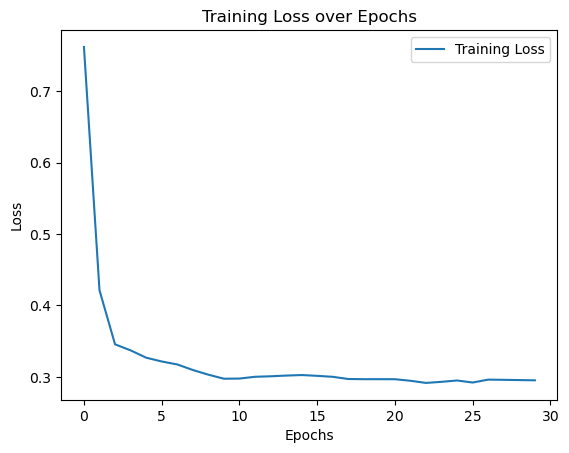

In [73]:
#visualize rnn training loss
plt.figure()
plt.plot(range(num_epochs), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()


### 5. Test RNN

In [74]:
#test RNN
custom_rnn.eval()

with torch.no_grad():
    y_hats_test, z_hats_test = custom_rnn(y_testing, u_testing) # Forward pass
    loss_y_test = lossfxn(y_hats_test, target_y_testing) # Compute loss
    loss_z_test = lossfxn(z_hats_test, target_z_testing)
    loss = loss_y_test + loss_z_test
    print(f'Test Loss (MSE): {loss.item():.8f}')


Test Loss (MSE): 0.47295620


#### Visualizing Gordon Data

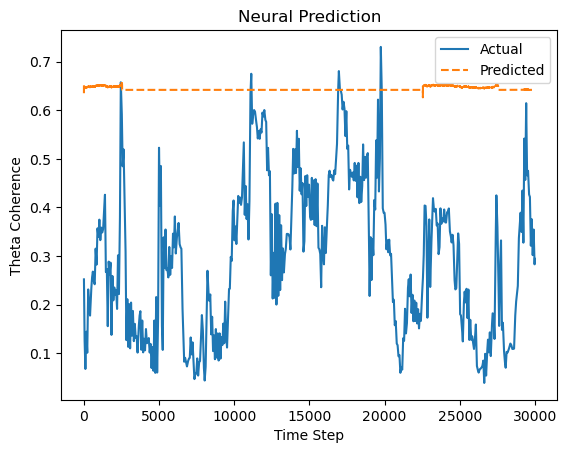

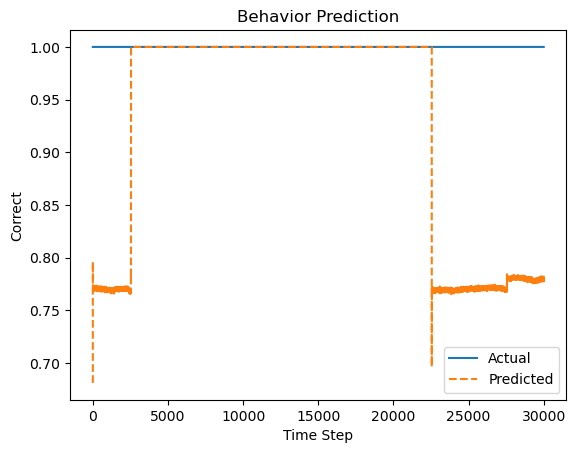

In [75]:
# Gordon Data - visualize theta coherence (neural) and behavioral error

# first convert tensors to numpy arrays for plotting
y_pred_testing_np = y_hats_test.numpy()
target_y_testing_np = target_y_testing.numpy()
z_pred_testing_np = z_hats_test.numpy()
target_z_testing_np = target_z_testing.numpy()

batch_idx = 30 #batch of testing data that you want to visualize

plt.plot(target_y_testing_np[batch_idx, :, 0], label='Actual')
plt.plot(y_pred_testing_np[batch_idx, :, 0], label='Predicted', linestyle = '--')
plt.title(f'Neural Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta Coherence')
plt.legend()
plt.show()
      
plt.plot(target_z_testing_np[batch_idx, :, 0], label='Actual')
plt.plot(z_pred_testing_np[batch_idx, :, 0], label='Predicted', linestyle = '--')
plt.title(f'Behavior Prediction')
plt.xlabel('Time Step')
plt.ylabel('Correct')
plt.legend()
plt.show()


#### Visualizing Stanley Data

IndexError: index 1 is out of bounds for axis 2 with size 1

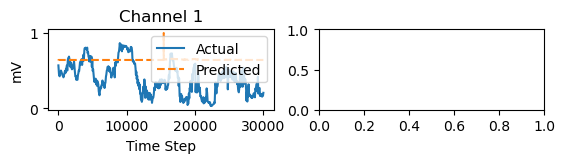

In [76]:
# Stanley Data - visualizes error of 8 channels at a time (neural)

W_A = custom_rnn.rnn_cell.W_A.weight.detach().numpy()                                            
W_K = custom_rnn.rnn_cell.W_K.weight.detach().numpy()                                      
W_B = custom_rnn.rnn_cell.W_B.weight.detach().numpy()
W_Cy = custom_rnn.W_Cy.weight.detach().numpy()   


# first convert tensors to numpy arrays for plotting
y_pred_testing_np = y_hats_test.numpy()
target_y_testing_np = target_y_testing.numpy()

batch_idx = 10 #batch of testing data that you want to visualize

yi = target_y_testing_np[batch_idx, 1, :]               # y0
W_CyI = np.linalg.pinv(W_Cy)
xi = W_CyI@yi                                           #x0

YSIM = []
yi = yi[:, None]
xi = xi[:, None]
YSIM.append(yi)

for i in range(1,10000):
    xi = W_A@xi + W_K@yi + W_B    #[5 x 5][5 x 1] + [5 x 32][32 x 1] + [5 x 1]
    if (i % 100 == 0):
        yi = target_y_testing_np[batch_idx, i, :]
        xi = W_CyI@yi  
        yi = yi[:, None]
        xi = xi[:, None]
        xi = W_A@xi + W_K@yi + W_B
    yi = W_Cy@xi                  #[32 x 1] = [32 x 5][5 x 1]
    YSIM.append(yi)   
YSIM = np.array(YSIM)



for i in range(8):
    plt.subplot(4, 2, i + 1)  # Adjust the subplot grid based on y_size
    plt.plot(target_y_testing_np[batch_idx, :, i], label='Actual')
    plt.plot(y_pred_testing_np[batch_idx, :, i], label='Predicted', linestyle = '--')
    plt.plot(YSIM[:, i, :],color='black', label='100 Step', ls=':')
    plt.title(f'Channel {i + 1}')
    plt.xlabel('Time Step')
    plt.ylabel('mV')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

for i in range(8):
    plt.subplot(4, 2, i + 1)  # Adjust the subplot grid based on y_size
    plt.plot(target_y_testing_np[batch_idx, :, i +8], label='Actual')
    plt.plot(y_pred_testing_np[batch_idx, :, i + 8], label='Predicted', linestyle = '--')
    plt.plot(YSIM[:, i + 8, :],color='black', label='100 Step', ls=':')
    plt.title(f'Channel {i + 1 + 8}')
    plt.xlabel('Time Step')
    plt.ylabel('mV')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

for i in range(8):
    plt.subplot(4, 2, i + 1)  # Adjust the subplot grid based on y_size
    plt.plot(target_y_testing_np[batch_idx, :, i + 16], label='Actual')
    plt.plot(y_pred_testing_np[batch_idx, :, i + 16], label='Predicted', linestyle = '--')
    plt.plot(YSIM[:, i + 16, :],color='black', label='100 Step', ls=':')
    plt.title(f'Channel {i + 1 + 16}')
    plt.xlabel('Time Step')
    plt.ylabel('mV')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()

for i in range(8):
    plt.subplot(4, 2, i + 1)  # Adjust the subplot grid based on y_size
    plt.plot(target_y_testing_np[batch_idx, :, i + 24], label='Actual')
    plt.plot(y_pred_testing_np[batch_idx, :, i + 24], label='Predicted', linestyle = '--')
    plt.plot(YSIM[:, i + 24, :],color='black', label='100 Step', ls=':')
    plt.title(f'Channel {i + 1 + 24}')
    plt.xlabel('Time Step')
    plt.ylabel('mV')
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


## RNN-IPSID Stage 1

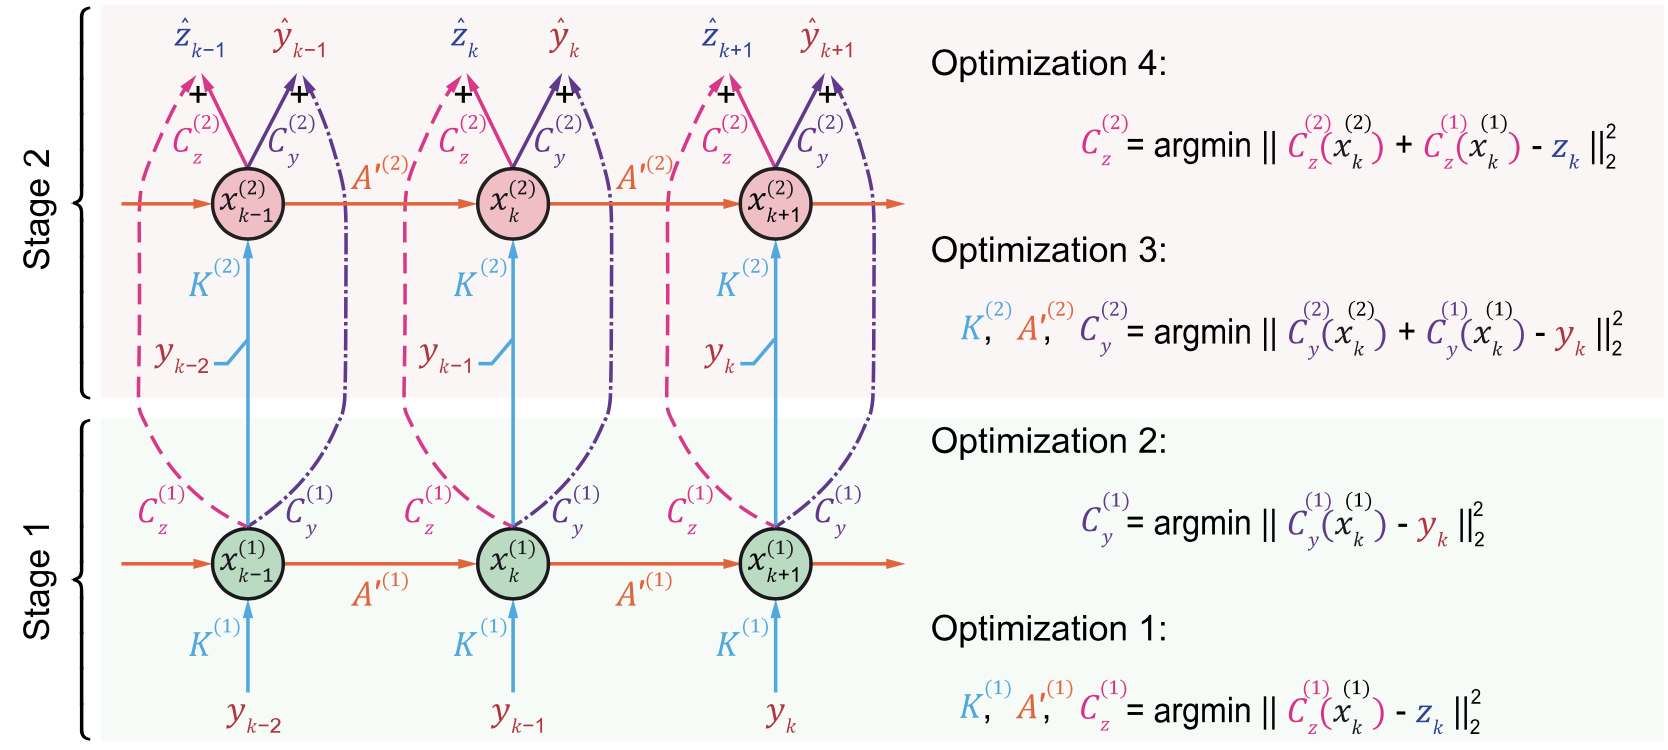

In [4]:
Image('src/rnn_ipsid_pic.png')


### 1. Choose RNN-IPSID parameters

In [14]:
#FOR TRAINING RNN-IPSID
x_size = 3
y_size = 2
u_size = 5
z_size = 1
yhat_size = 1
zhat_size = 1


### 2. Choose between linear or nonlinear RNN-IPSID

#### Linear:

In [9]:
#instantiate the linear custom RNN for Stage 1
stage1_optim1 = rnn_ipsid.Optim1(x_size, y_size, u_size, yhat_size, zhat_size)
stage1_optim2 = rnn_ipsid.Optim2(x_size, yhat_size)


#### Nonlinear

In [31]:
#instatiate the nonlinear custom RNN
stage1_optim1 = rnn_ipsid_nonLin.Optim1(x_size, y_size, u_size, yhat_size, zhat_size)
stage1_optim2 = rnn_ipsid_nonLin.Optim2(x_size, yhat_size)


### 3. Optimization

In [32]:
lr = 0.05

#instantiate loss function and optimizer
lossfxn = nn.MSELoss()
optimizer_optim1 = optim.Adam(stage1_optim1.parameters(), lr=lr) 
optimizer_optim2 = optim.Adam(stage1_optim2.parameters(), lr=lr) 


### 4. Train RNN-IPSID

#### Stage 1, Part 1

In [33]:
#TRAIN RNN-IPSID Stage 1 pt 1

#Training Optimizer 1: Learning Parameters A'(1), Cz(1), and K(1) and estimating its latent state x(1) while minimizing behavior loss

num_epochs = 30
train_lossesZ = []

for epoch in range(num_epochs):
    optimizer_optim1.zero_grad() #reset gradients
    z_hats_train, behavStates = stage1_optim1(y_training, u_training) #forward pass
    loss_z = lossfxn(z_hats_train, target_z_training) #computes loss between behavioral data predicted (z_hat) and truth (target_z)
    loss_z.backward() #backwards pass - computes gradients only based on behavioral (z)
    optimizer_optim1.step() #updates K, A, and Cz
    train_lossesZ.append(loss_z.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_z: {loss_z.item():.8f}')

xBehav_states_part1_training = behavStates.detach() #drops the gradients to prevent carrying over operations from this computational graph
z_hats_part1_training = z_hats_train.detach()


Epoch [1/30], Loss_z: 0.44589761
Epoch [2/30], Loss_z: 0.32662374
Epoch [3/30], Loss_z: 0.31050896
Epoch [4/30], Loss_z: 0.30364614
Epoch [5/30], Loss_z: 0.29905325
Epoch [6/30], Loss_z: 0.29452581
Epoch [7/30], Loss_z: 0.29106813
Epoch [8/30], Loss_z: 0.28830858
Epoch [9/30], Loss_z: 0.28594316
Epoch [10/30], Loss_z: 0.28384755
Epoch [11/30], Loss_z: 0.28195827
Epoch [12/30], Loss_z: 0.28013943
Epoch [13/30], Loss_z: 0.27822730
Epoch [14/30], Loss_z: 0.27602169
Epoch [15/30], Loss_z: 0.27334802
Epoch [16/30], Loss_z: 0.26982297
Epoch [17/30], Loss_z: 0.26467446
Epoch [18/30], Loss_z: 0.25806751
Epoch [19/30], Loss_z: 0.25775603
Epoch [20/30], Loss_z: 0.25775883
Epoch [21/30], Loss_z: 0.25775052
Epoch [22/30], Loss_z: 0.25774912
Epoch [23/30], Loss_z: 0.25773762
Epoch [24/30], Loss_z: 0.25771844
Epoch [25/30], Loss_z: 0.25768556
Epoch [26/30], Loss_z: 0.25763835
Epoch [27/30], Loss_z: 0.25757471
Epoch [28/30], Loss_z: 0.25749823
Epoch [29/30], Loss_z: 0.25740619
Epoch [30/30], Loss_z: 

##### Training Loss Part 1 Visualization

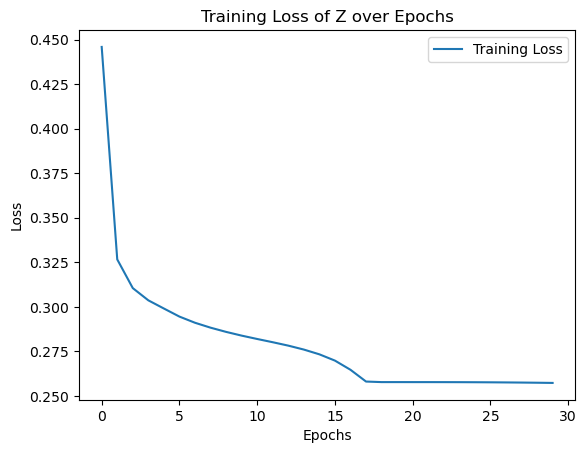

In [34]:
#visualize rnn-ipsid training loss
plt.figure()
plt.plot(range(num_epochs), train_lossesZ, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of Z over Epochs')
plt.legend()
plt.show()


#### Stage 1, Part 2

In [35]:
#TRAIN RNN-IPSID Stage 1 pt 2

#Training Optimizer 2: uses extracted latent states x(1) from optimization 1 to learn parameter Cy(1) while minimizing neural loss

num_epochs = 30
train_lossesY = []

for epoch in range(num_epochs):
    optimizer_optim2.zero_grad() #reset gradients
    y_hats_train = stage1_optim2(xBehav_states_part1_training) #forward pass
    loss_y = lossfxn(y_hats_train, target_y_training) #computes loss between neural data predicted (y_hat) and truth (target_y)
    loss_y.backward() #backwards pass - computes gradients only based on neural (y)
    optimizer_optim2.step() #updates Cy
    train_lossesY.append(loss_y.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_y: {loss_y.item():.8f}')

y_hats_part1_training = y_hats_train.detach()


/opt/anaconda3/envs/aim3/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1129, 10000, 2])) that is different to the input size (torch.Size([1129, 10000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/30], Loss_y: 4117845.46661355
Epoch [2/30], Loss_y: 4117814.27654547
Epoch [3/30], Loss_y: 4117745.50929646
Epoch [4/30], Loss_y: 4117721.01909357
Epoch [5/30], Loss_y: 4117683.72251571
Epoch [6/30], Loss_y: 4117660.60049443
Epoch [7/30], Loss_y: 4117661.76551129
Epoch [8/30], Loss_y: 4117665.52205379
Epoch [9/30], Loss_y: 4117666.71266092
Epoch [10/30], Loss_y: 4117666.10341888
Epoch [11/30], Loss_y: 4117663.16981022
Epoch [12/30], Loss_y: 4117659.29436195
Epoch [13/30], Loss_y: 4117655.78368486
Epoch [14/30], Loss_y: 4117654.20092024
Epoch [15/30], Loss_y: 4117655.43565525
Epoch [16/30], Loss_y: 4117656.31618816
Epoch [17/30], Loss_y: 4117655.07550268
Epoch [18/30], Loss_y: 4117652.67745625
Epoch [19/30], Loss_y: 4117650.77439606
Epoch [20/30], Loss_y: 4117650.07545944
Epoch [21/30], Loss_y: 4117650.11968349
Epoch [22/30], Loss_y: 4117650.27572384
Epoch [23/30], Loss_y: 4117649.74752461
Epoch [24/30], Loss_y: 4117648.68607307
Epoch [25/30], Loss_y: 4117647.41484811
Epoch [26

##### Training Loss Part 2 Visualization

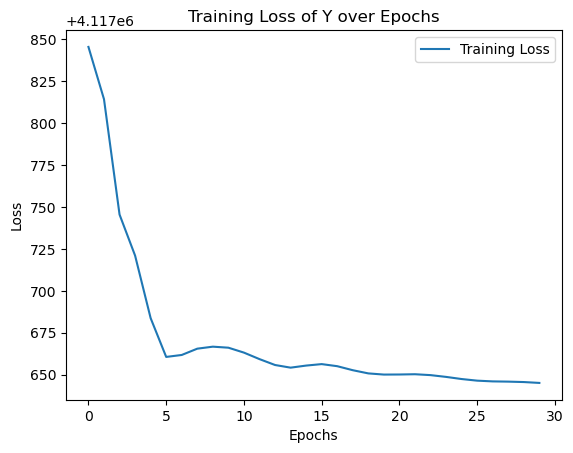

In [36]:
#visualize rnn-ipsid training loss
plt.figure()
plt.plot(range(num_epochs), train_lossesY, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of Y over Epochs')
plt.legend()
plt.show()


### 5. Test RNN-IPSID

#### Test Stage 1, Part 1

In [37]:
#test RNN-IPSID Stage 1, Part 1

stage1_optim1.eval()

with torch.no_grad():
    z_hats_test, behavStates = stage1_optim1(y_testing, u_testing) #forward pass
    loss_z_test = lossfxn(z_hats_test, target_z_testing)
    print(f'Test Loss (MSE): {loss_z_test.item():.8f}')

xBehav_states_part1_testing = behavStates.detach() #drops the gradients to prevent carrying over operations from this computational graph
z_hats_part1_testing = z_hats_test.detach()


Test Loss (MSE): 0.38095509


##### Visualizing Gordon Data for Stage 1, Part 1

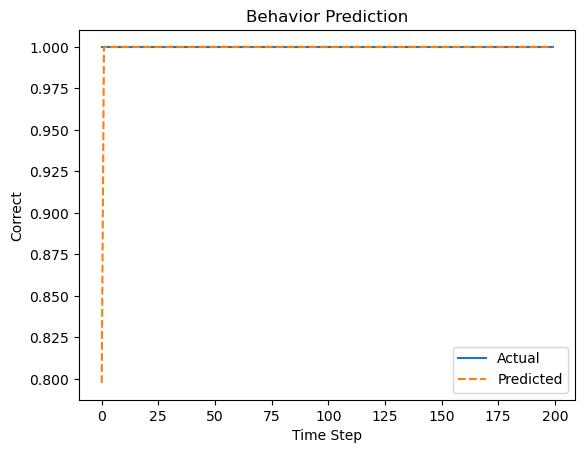

In [29]:
# Gordon Data - visualize behavioral error

# first convert tensors to numpy arrays for plotting
z_pred_testing_np = z_hats_test.numpy()
target_z_testing_np = target_z_testing.numpy()

batch_idx = 14122 #batch of testing data that you want to visualize
      
plt.plot(target_z_testing_np[batch_idx, :, 0], label='Actual')
plt.plot(z_pred_testing_np[batch_idx, :, 0], label='Predicted', linestyle = '--')
plt.title(f'Behavior Prediction')
plt.xlabel('Time Step')
plt.ylabel('Correct')
plt.legend()
plt.show()


##### Cannot Visualize Stanley Data for Stage 1, Part 1 (no behavioral)

#### Test Stage 1, Part 2

In [88]:
#test RNN-IPSID Stage 1, Part 2
stage1_optim2.eval()

with torch.no_grad():
    y_hats_test = stage1_optim2(xBehav_states_part1_testing) #forward pass
    loss_y_test = lossfxn(y_hats_test, target_y_testing)
    print(f'Test Loss (MSE): {loss_y_test.item():.8f}')

y_hats_part1_testing = y_hats_test.detach()



Test Loss (MSE): 0.34570226


##### Visualizing Gordon Data for Stage 1, Part 2

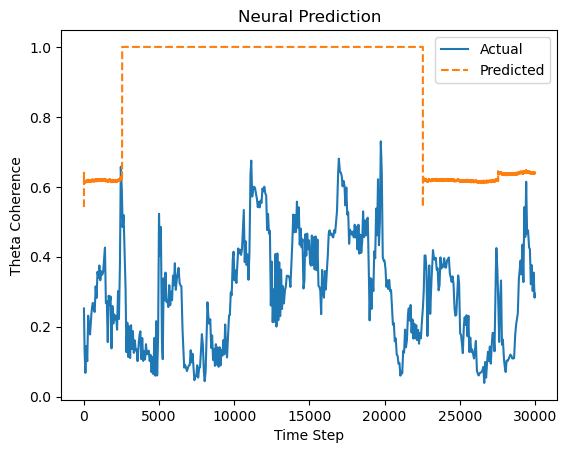

In [89]:
# Gordon Data - visualize theta coherence (neural)

# first convert tensors to numpy arrays for plotting
y_pred_testing_np = y_hats_test.numpy()
target_y_testing_np = target_y_testing.numpy()

batch_idx = 30 #batch of testing data that you want to visualize

plt.plot(target_y_testing_np[batch_idx, :, 0], label='Actual')
plt.plot(y_pred_testing_np[batch_idx, :, 0], label='Predicted', linestyle = '--')
plt.title(f'Neural Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta Coherence')
plt.legend()
plt.show()


##### Cannot isualize Stanley Data for Stage 1, Part 2 (no behvaioral to begin with)

## RNN-IPSID Stage 2 (Optional)

### 1. Choose Parameters (Neural State size)

In [90]:
xBehavioral_size = x_size
xNeural_size = 5 # "𝑥_𝑘(2) ∈R 𝑛_2 , where 𝑛_2 = 𝑛_𝑥 − 𝑛_1"


### 2. Choose between linear or nonlinear

#### Linear:

In [91]:
#instantiate the linear custom RNN for Stage 1
stage2_optim3 = rnn_ipsid.Optim3(xBehavioral_size, xNeural_size, y_size, u_size, yhat_size, zhat_size)
stage2_optim4 = rnn_ipsid.Optim4(xNeural_size, zhat_size)


#### Nonlinear:

In [92]:
#instatiate the nonlinear custom RNN
stage2_optim3 = rnn_ipsid_nonLin.Optim3(xBehavioral_size, xNeural_size, y_size, u_size, yhat_size, zhat_size)
stage2_optim4 = rnn_ipsid_nonLin.Optim4(xNeural_size, zhat_size)


### 3. Optimization

In [93]:
lr = 0.05

#instantiate loss function and optimizer
lossfxn = nn.MSELoss()
optimizer_optim3 = optim.Adam(stage2_optim3.parameters(), lr=lr) 
optimizer_optim4 = optim.Adam(stage2_optim4.parameters(), lr=lr) 


### 4. Train RNN-IPSID

#### Stage 2, Part 1

In [94]:
#TRAIN RNN-IPSID Stage 2 pt 1

#Training Optimizer 3: Learn 𝐴′(2), 𝐾(2), and 𝐶𝑦(2) by fitting an RNN that minimizes the error in neural prediction when using 
# the past neural activity and the states extracted from the first RNN 𝑥𝑘(1) as input 

num_epochs = 30
train_lossesYtotal = []

for epoch in range(num_epochs): 
    optimizer_optim3.zero_grad() #reset gradients
    y_hats_part2_training, xNeural_states = stage2_optim3(xBehav_states_part1_training, y_training, u_training) #forward pass
    y_hat_total = y_hats_part1_training + y_hats_part2_training
    loss_y = lossfxn(y_hat_total, target_y_training) #computes loss between neural data predicted from both parts (y_hat_p1 + y_hat_pt2) and truth (target_y)
    loss_y.backward() #backwards pass - computes gradients only based on behavioral (z)
    optimizer_optim3.step() #updates K(2), A(2), and Cy(2)
    train_lossesYtotal.append(loss_y.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_y: {loss_y.item():.8f}')

xNeural_states_training = xNeural_states.detach() #drops the gradients to prevent carrying over operations from this computational graph


Epoch [1/30], Loss_y: 0.18323965
Epoch [2/30], Loss_y: 0.10884554
Epoch [3/30], Loss_y: 0.08431323
Epoch [4/30], Loss_y: 0.08441229
Epoch [5/30], Loss_y: 0.08443125
Epoch [6/30], Loss_y: 0.08443216
Epoch [7/30], Loss_y: 0.08443190
Epoch [8/30], Loss_y: 0.08443163
Epoch [9/30], Loss_y: 0.08443141
Epoch [10/30], Loss_y: 0.08443122
Epoch [11/30], Loss_y: 0.08443105
Epoch [12/30], Loss_y: 0.08443090
Epoch [13/30], Loss_y: 0.08443076
Epoch [14/30], Loss_y: 0.08443064
Epoch [15/30], Loss_y: 0.08443052
Epoch [16/30], Loss_y: 0.08443042
Epoch [17/30], Loss_y: 0.08443033
Epoch [18/30], Loss_y: 0.08443025
Epoch [19/30], Loss_y: 0.08443017
Epoch [20/30], Loss_y: 0.08443010
Epoch [21/30], Loss_y: 0.08443004
Epoch [22/30], Loss_y: 0.08442998
Epoch [23/30], Loss_y: 0.08442992
Epoch [24/30], Loss_y: 0.08442987
Epoch [25/30], Loss_y: nan
Epoch [26/30], Loss_y: nan
Epoch [27/30], Loss_y: nan
Epoch [28/30], Loss_y: nan
Epoch [29/30], Loss_y: nan
Epoch [30/30], Loss_y: nan


##### Training Loss Part 1 Visualization

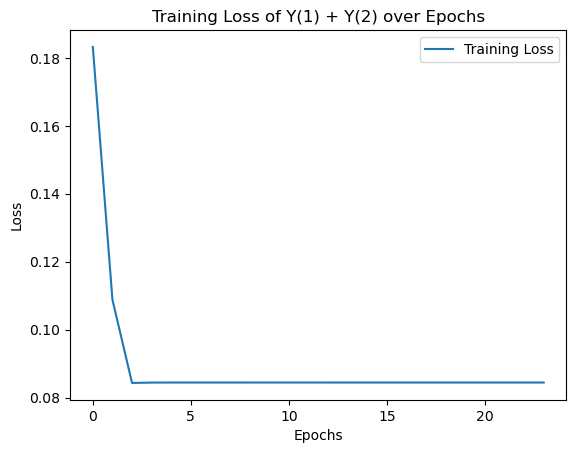

In [95]:
#visualize rnn-ipsid training loss
plt.figure()
plt.plot(range(num_epochs), train_lossesYtotal, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of Y(1) + Y(2) over Epochs')
plt.legend()
plt.show()


#### Stage 2, Part 2

In [96]:
#TRAIN RNN-IPSID Stage 2 pt 2

#Training Optimizer 4:  Learn 𝐶𝑧(2)by minimzing neural prediction error when using the second RNN states 𝑥𝑘(2) as input
num_epochs = 30
train_lossesZtotal = []

for epoch in range(num_epochs):
    optimizer_optim4.zero_grad() #reset gradients
    z_hats_part2_training = stage2_optim4(xNeural_states_training) #forward pass
    z_hat_total = z_hats_part1_training + z_hats_part2_training
    loss_z = lossfxn(z_hat_total, target_z_training) #computes loss between neural data predicted (y_hat) and truth (target_y)
    loss_z.backward() #backwards pass - computes gradients only based on neural (y)
    optimizer_optim4.step() #updates Cz2
    train_lossesZtotal.append(loss_z.item())
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss_z: {loss_z.item():.8f}')


Epoch [1/30], Loss_z: nan
Epoch [2/30], Loss_z: nan
Epoch [3/30], Loss_z: nan
Epoch [4/30], Loss_z: nan
Epoch [5/30], Loss_z: nan
Epoch [6/30], Loss_z: nan
Epoch [7/30], Loss_z: nan
Epoch [8/30], Loss_z: nan
Epoch [9/30], Loss_z: nan
Epoch [10/30], Loss_z: nan
Epoch [11/30], Loss_z: nan
Epoch [12/30], Loss_z: nan
Epoch [13/30], Loss_z: nan
Epoch [14/30], Loss_z: nan
Epoch [15/30], Loss_z: nan
Epoch [16/30], Loss_z: nan
Epoch [17/30], Loss_z: nan
Epoch [18/30], Loss_z: nan
Epoch [19/30], Loss_z: nan
Epoch [20/30], Loss_z: nan
Epoch [21/30], Loss_z: nan
Epoch [22/30], Loss_z: nan
Epoch [23/30], Loss_z: nan
Epoch [24/30], Loss_z: nan
Epoch [25/30], Loss_z: nan
Epoch [26/30], Loss_z: nan
Epoch [27/30], Loss_z: nan
Epoch [28/30], Loss_z: nan
Epoch [29/30], Loss_z: nan
Epoch [30/30], Loss_z: nan


##### Training Loss Part 2 Visualization

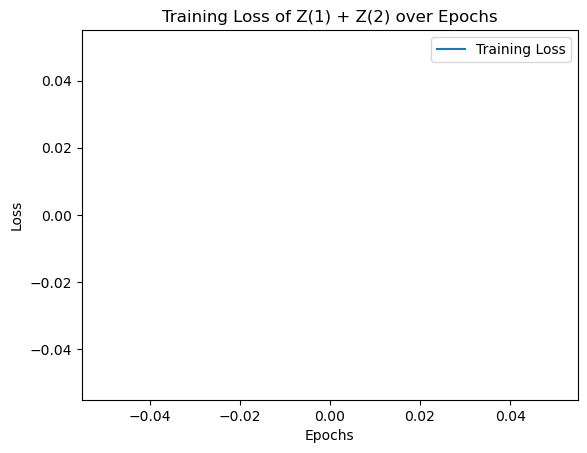

In [97]:
#visualize rnn-ipsid training loss
plt.figure()
plt.plot(range(num_epochs), train_lossesZtotal, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss of Z(1) + Z(2) over Epochs')
plt.legend()
plt.show()


### 5. Test RNN-IPSID

#### Test Stage 2, Part 1

In [98]:
#test RNN-IPSID Stage 2, Part 1

stage2_optim3.eval()

with torch.no_grad():
    y_hats_part2_testing, xNeural_states = stage2_optim3(xBehav_states_part1_testing, y_testing, u_testing) #forward pass
    loss_y_test = lossfxn(y_hats_part2_testing, target_y_testing)
    print(f'Test Loss (MSE): {loss_y_test.item():.8f}')

xNeural_states_testing = xNeural_states.detach() #drops the gradients to prevent carrying over operations from this computational graph



Test Loss (MSE): nan


##### Visualizing Gordon Data for Stage 2, Part 2

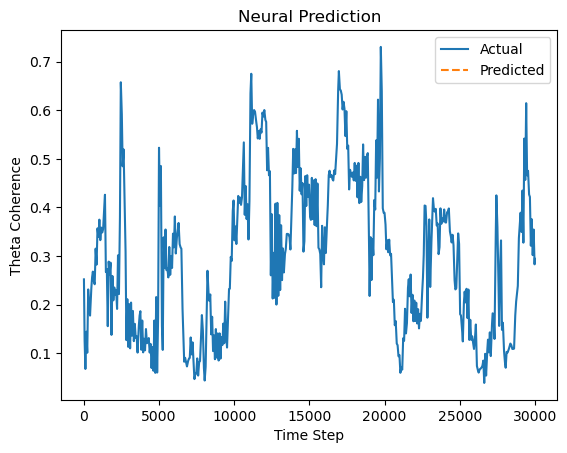

In [99]:
# Gordon Data - visualize theta coherence (neural)

# first convert tensors to numpy arrays for plotting
y_pred_testing_np = y_hats_part2_testing.numpy()
target_y_testing_np = target_y_testing.numpy()

batch_idx = 30 #batch of testing data that you want to visualize

plt.plot(target_y_testing_np[batch_idx, :, 0], label='Actual')
plt.plot(y_pred_testing_np[batch_idx, :, 0], label='Predicted', linestyle = '--')
plt.title(f'Neural Prediction')
plt.xlabel('Time Step')
plt.ylabel('Theta Coherence')
plt.legend()
plt.show()


##### Cannot Visualize Stanley Data for Stage 2, Part 2 (no behavioral)

#### Test Stage 2, Part 2

In [100]:
#test RNN-IPSID Stage 2, Part 2
stage2_optim4.eval()

with torch.no_grad():
    z_hats_part2_testing = stage2_optim4(xNeural_states_testing) #forward pass
    loss_z_test = lossfxn(z_hats_part2_testing, target_z_testing)
    print(f'Test Loss (MSE): {loss_y_test.item():.8f}')


Test Loss (MSE): nan


##### Visualizing Gordon Data for Stage 2, Part 2

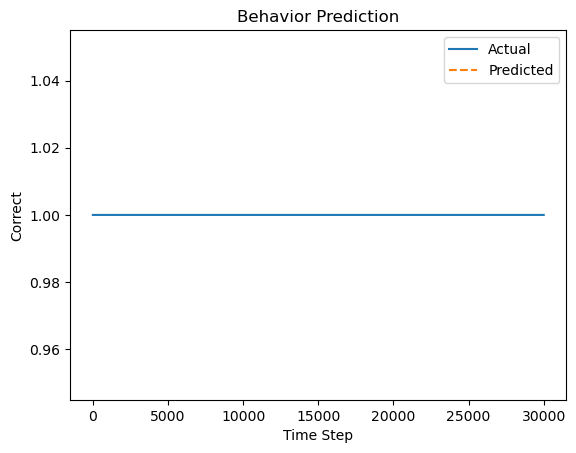

In [101]:
# Gordon Data - visualize behavioral error

# first convert tensors to numpy arrays for plotting
z_pred_testing_np = z_hats_part2_testing.numpy()
target_z_testing_np = target_z_testing.numpy()

batch_idx = 30 #batch of testing data that you want to visualize
      
plt.plot(target_z_testing_np[batch_idx, :, 0], label='Actual')
plt.plot(z_pred_testing_np[batch_idx, :, 0], label='Predicted', linestyle = '--')
plt.title(f'Behavior Prediction')
plt.xlabel('Time Step')
plt.ylabel('Correct')
plt.legend()
plt.show()


##### Cannot Visualize Stanley Data for Stage 2, Part 2 (no behvaioral to begin with)